### 1. What is the purpose of this experiment?
LGBMのkernelにおける学習時間を計測する
### 2. Why do you this?
CPUで攻めるかGPUで攻めるか判断する.GPUの場合もLGBMを使うか判断する
### 3. Where are the points of technology and techniques?
LGBM
### 4. How do you validate the effectiveness?
処理時間
### 5. What will you do next?
NN * FE

In [3]:
is_local = False
seed = 1208

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
import datetime
import sys
import re
import gc
import glob
import pickle as pkl
import os

from joblib import Parallel, delayed
from multiprocessing import Pool
import multiprocessing
def pararell_process(func, arg_list, cpu_cnt=multiprocessing.cpu_count()):
    process = Pool(cpu_cnt)
    callback = process.map_async(func, arg_list).get(600)
    process.close()
    process.terminate()
    return callback

def mkdir_func(path):
    try:
        os.stat(path)
    except:
        os.mkdir(path)

from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
def logger_func():
    logger = getLogger(__name__)
    log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s]\
    [%(funcName)s] %(message)s ')
    handler = StreamHandler()
    handler.setLevel('INFO')
    handler.setFormatter(log_fmt)
    logger.addHandler(handler)

    mkdir_func('../output')
    handler = FileHandler('../output/py_train.py.log', 'a')
    handler.setLevel(DEBUG)
    handler.setFormatter(log_fmt)
    logger.setLevel(DEBUG)
    logger.addHandler(handler)

    logger.info('start')

    return logger
logger = logger_func()

st_time = time.time()
@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
# NLP
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string

key = 'qid'
qt = 'question_text'
target = 'target'

2018-11-27 09:32:29,524 __main__ 51 [INFO]    [logger_func] start 


### Cleansing Method

In [4]:
# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
#     clean = re.sub(b" ", b"# #", clean)  # Replace space
#     clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def cleansing_text(text, remove_stopwords=True):

    # Convert words to lower case and split them
    text = re.sub("_", " ", text, flags=re.IGNORECASE)
    text = text.lower().split()
    regex_num = re.compile(u"[0-9０-９]")

    # Optionally, remove stop words
    if remove_stopwords:
        stops = STOPWORDS
        text = [w for w in text if (not w in stops) and not(regex_num.match(w))]

    text = " ".join(text)

    # Clean the text
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub("\'ve", " have ", text)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("`", "'", text) # special single quote
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("é", "e", text)
    text = re.sub("’", "'", text) # special single quote
    text = re.sub("“", '"', text) # special double quote
    text = re.sub("…", " ", text)
    text = re.sub("？", "?", text)
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\W|^)([0-9]+)[kK](\W|$)", r"\1\g<2>000\3", text) # better regex provided by @armamut
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"what's", "what is ", text)

    # Original
    text = re.sub(r" u s ", " America ", text)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" qoura ", " Quora ", text)
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r"(?=[a-zA-Z])ig ", "ing ", text)
    
    return text

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }    
def clean_map_text(x):
    for dic in [contraction_mapping, mispell_dict, punct_mapping]:
        for word in dic.keys():
            x = x.replace(word, dic[word])
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'
                }
mispellings, mispellings_re = _get_mispell(mispell_dict)

def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

### Data Load

In [5]:
def quara_load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    return train, test

train, test = quara_load_data()
# Load id Text List
train_id_list = list(train[key].values)
test_id_list = list(test[key].values)
train_text_list = list(train[qt].values)
test_text_list = list(test[qt].values)
id_list = train_id_list + test_id_list
text_list = train_text_list + test_text_list

raw_trn_idx = list(train.index)
raw_test_idx = list(test.index)
y = train[target]

del train, test
gc.collect()

print(train_text_list[:10])

['How did Quebec nationalists see their province as a nation in the 1960s?', 'Do you have an adopted dog, how would you encourage people to adopt and not shop?', 'Why does velocity affect time? Does velocity affect space geometry?', 'How did Otto von Guericke used the Magdeburg hemispheres?', 'Can I convert montra helicon D to a mountain bike by just changing the tyres?', 'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?', 'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?', 'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.', 'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?', 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?']


### Cleansing Start

In [6]:
# Cleansing
with timer("Cleansing Dataset"):
    # 並列処理でクレンジング
    train_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in train_text_list] )
    train_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in train_text_list] )
    train_text_list = Parallel(n_jobs=-1)( [delayed(clean_map_text)(args) for args in train_text_list] )
    train_text_list = Parallel(n_jobs=-1)( [delayed(replace_typical_misspell)(args) for args in train_text_list] )
    
    test_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in test_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in test_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(clean_map_text)(args) for args in test_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(replace_typical_misspell)(args) for args in test_text_list] )
    
    text_list = train_text_list + test_text_list

[Cleansing Dataset] done in 111 s


### TFIDF
ngramはいくつかパターンを試す
実験のため、tfidf matrixとvecotorizerは保存しておく

In [7]:
ngram_range=(1,1)
# ngram_range=(1,2)
max_features = 10000

def get_tfidf(text_list):
    '''
    Explain:
        テキストを1要素としてもったリストを渡し、TFIDFベクトルをもったsparse matrixを出力する
    Args:
        text_list(list): split前のテキストリスト. 1テキストが1つのTFIDFベクトルに変換される
    Return:
        sparse csr_matrix: TFIDF値が入ったスパースな行列
    '''
    # Get the tfidf
    with timer("Fitting TFIDF"):
        # TFIDFに変換するオブジェクトを作成する
        tfidf_vectorizer = TfidfVectorizer(
            max_features = max_features,
            min_df=10,
            max_df=0.5,
            stop_words="english",
            analyzer='word',
            #  analyzer='char',
            strip_accents='unicode',
            ngram_range=ngram_range,
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        ).fit(text_list)

    # Train, Testのテキストが順番に並んだリストを渡すと、各テキストをTFIDFベクトルに変換して返してくれる
    # テキストに対応するインデックスを渡して返ってくるのが対応するTFIDFベクトル
    with timer("Transform TFIDF"):
        csr_tfidf = tfidf_vectorizer.transform(text_list)
    return csr_tfidf, tfidf_vectorizer

# TFIDF
csr_tfidf, tfidf_vectorizer = get_tfidf(text_list)

# Kernel実行の場合は分岐
if is_local:
    HOME = os.path.expanduser("~")
    sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
    import utils
    utils.to_pkl_gzip(obj=tfidf_vectorizer, path='../input/bench_vectorizer_tfidf30000.gz')
    utils.to_pkl_gzip(obj=csr_tfidf, path='../input/bench_csr_tfidf30000.gz')
    sys.path.append(f'{HOME}/kaggle/data_analysis/model')
    from params_lgbm import params_quara
else:
    del text_list
    gc.collect()

[Fitting TFIDF] done in 10 s
[Transform TFIDF] done in 10 s


### LGBM

In [8]:
train_st_time = time.time()
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

# Variables
try:
    tfidf_vocablary = tfidf_vectorizer.vocabulary_.items()
    feature_list = np.array(tfidf_vectorizer.get_feature_names())
    del tfidf_vectorizer
    gc.collect()
except NameError:
    pass

def f1_calculation(y_val, y_pred):
    for thresh in np.arange(0.1, 0.401, 0.01):
        thresh = np.round(thresh, 2)
        f1 = f1_score(y_val, (y_pred>thresh).astype(int))
        logger.info(f"F1 score at threshold {thresh} is {f1}")
        
        
# Memory Error
def start_svd(df_tfidf, dim=1000):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=dim, random_state=seed)
    svd_tfidf = svd.fit_transform(df_tfidf)
#     col_names = [f"svd{dim}_tfidf_{i}" for i in range(dim)]
#     df_svd = pd.DataFrame(svd_tfidf, columns=col_names)
    return svd_tfidf
    

def lgbm_train(train_test, feature_list, fold):

    # LGBM Args
    model_type = 'lgb'
    fold_type = 'stratified'
    metric = 'accuracy'
#     fold = 5
    learning_rate = 0.1
    early_stopping_rounds = 100
    num_boost_round = 10000
    seed = 1208
    params = {
        'num_threads': -1,
        'metric': 'binary_logloss',
        'objective': 'binary',
        'boosting_type':'gbdt',
        'bagging_freq': 1,
        'sigmoid': 1.1,
        'subsample': 0.9,
        'colsample_bytree': 0.2,
        'lambda_l1': 1,
        'lambda_l2': 5,
        'learning_rate': 0.1,
        'num_leaves': 100,
        'max_depth': 9,
        'bagging_seed': 1208,
        'data_random_seed': 1208,
        'feature_fraction_seed': 1208,
        'random_seed': 1208,
        'verbose': 1
    }

    # Result
    select_features = [] # Feature Importanceによって選択したfeature群を入れるリスト
    prediction = np.zeros(len(raw_trn_idx))

    with timer("LGBM Setting"):

        # testも結合されてるので、trainのみにする
#         tmp_train = csr_tfidf[raw_trn_idx]
        tmp_train = train_test[raw_trn_idx]

        ' KFold '
        if fold_type == 'stratified':
            folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
            kfold = folds.split(tmp_train, y)

    cv_feim = pd.DataFrame() # Feature Importanceの結果ファイルを入れるDF
    for n_fold, (trn_idx, val_idx) in enumerate(kfold):

        with timer(f"Validation: {n_fold} | LGBM Train"):
            x_train, y_train = tmp_train[trn_idx], y[trn_idx]
            x_val, y_val = tmp_train[val_idx], y[val_idx]

            # Dataset
            lgb_train = lgb.Dataset(data=x_train, label=y_train)
            lgb_eval = lgb.Dataset(data=x_val, label=y_val)

            estimator = lgb.train(
                train_set=lgb_train,
                valid_sets=lgb_eval,
                params=params,
                verbose_eval=200,
                early_stopping_rounds=early_stopping_rounds,
                num_boost_round=num_boost_round
            )
            
#         start_time = time.time()
        
#         def score(X, y):
#             y_pred = estimator.predict(X)
#             return accuracy_score(y, y_pred)
#         base_score, score_decreases = get_score_importances(score, x_train, y_train)
#         feature_importances = np.mean(score_decreases, axis=0)
        
#         from matplotlib import pyplot as plt
#         %matplotlib inline
#         import seaborn as sns
        
#         plt.figure(figsize=(8, 12))
#         sns.barplot(data=[feature_importances[:50], feature_list[:50]], x='avg_importance', y='feature')
#         plt.show()
        
#         total_time = (time.time() - start_time)/60.0
#         print(f"Permutation Importance Calculate: {total_time}")
#         sys.exit()

        with timer(f"Validation: {n_fold} | Prediction & Get F1 score"):
            y_pred = estimator.predict(x_val)
            score = log_loss(y_val, y_pred)
            logger.info(f'Fold No: {n_fold} | {metric}: {score}')
            logger.info(f"Train Shape: {x_train.shape}")
            
            prediction[val_idx] = y_pred
            
            f1_calculation(y_val, y_pred)

            ' Feature Importance '
            if len(cv_feim):
                cv_feim[f'{n_fold}_importance'] = estimator.feature_importance(importance_type='gain')
            else:
                feim_name = f'{n_fold}_importance'
                feim = pd.Series(estimator.feature_importance(importance_type='gain'), name=feim_name, index=feature_list).to_frame().reset_index().rename(columns={'index':'feature'})
                cv_feim = feim.copy()
                
    f1_calculation(y, prediction)

    with timer("Save Feature Importance"):
        col_feim = [col for col in cv_feim.columns if col.count('importance')]
        cv_feim['avg_importance'] = cv_feim[col_feim].mean(axis=1)
        cv_feim.sort_values(by='avg_importance', ascending=False, inplace=True)

        if is_local:
            cv_feim.to_csv(f'../valid/{start_time[4:12]}_{model_type}_TFIDF_f1{f1}_logloss{score}_lr{learning_rate}.csv', index=False)
        tmp_features = list(cv_feim[cv_feim['avg_importance']>30]['feature'].values)
        print(f'Selece Feature: {len(tmp_features)}')
        select_features += tmp_features

    select_features = list(set(select_features))
    print(len(select_features))
    print(sorted(select_features)[:20])
    print(f'All done in {time.time() - train_st_time:.0f} s')
    
    return select_features, prediction

In [9]:
csr_tfidf.shape

(1362492, 10000)

[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.230375
[400]	valid_0's binary_logloss: 0.230351
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.230349
[Validation: 0 | LGBM Train] done in 6 s


2018-11-27 09:37:34,288 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.23034927082984202 
2018-11-27 09:37:34,291 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 100) 
2018-11-27 09:37:34,388 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.0472527714720208 
2018-11-27 09:37:34,471 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.04465303385853167 
2018-11-27 09:37:34,554 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.04306930693069307 
2018-11-27 09:37:34,638 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.04119314959736872 
2018-11-27 09:37:34,722 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.04028100907805301 
2018-11-27 09:37:34,806 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.03791447413773295 
2018-11-27 09:37:34,890 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.03638882475178942 
2018-11-27 0

[Validation: 0 | Prediction & Get F1 score] done in 4 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.23035
[400]	valid_0's binary_logloss: 0.230311
Early stopping, best iteration is:
[415]	valid_0's binary_logloss: 0.230309
[Validation: 1 | LGBM Train] done in 6 s


2018-11-27 09:37:44,332 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.2303090025876182 
2018-11-27 09:37:44,336 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 100) 
2018-11-27 09:37:44,434 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.0481240885589288 
2018-11-27 09:37:44,519 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.04637564720585609 
2018-11-27 09:37:44,603 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.044849901132482474 
2018-11-27 09:37:44,687 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.04290541306664852 
2018-11-27 09:37:44,771 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.04207937700662613 
2018-11-27 09:37:44,854 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.04072212065813528 
2018-11-27 09:37:44,939 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.03822654646900145 
2018-11-27 0

[Validation: 1 | Prediction & Get F1 score] done in 4 s


2018-11-27 09:37:47,144 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.04768787721640498 
2018-11-27 09:37:47,341 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.04551494645628845 
2018-11-27 09:37:47,536 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.04396024464831805 
2018-11-27 09:37:47,731 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.04204939783629312 
2018-11-27 09:37:47,926 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.04118096149682653 
2018-11-27 09:37:48,120 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.03932217371876397 
2018-11-27 09:37:48,314 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.03730835342570054 
2018-11-27 09:37:48,509 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.03560741376510705 
2018-11-27 09:37:48,703 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18

,feature,0_importance,1_importance,avg_importance
51,accept,2188.883690,2035.842187,2112.362938
18,abortion,1199.497186,1393.128094,1296.312640
69,account,891.180933,774.580492,832.880712
33,abuse,713.494702,619.144365,666.319533
94,acknowledge,555.380083,544.477623,549.928853


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


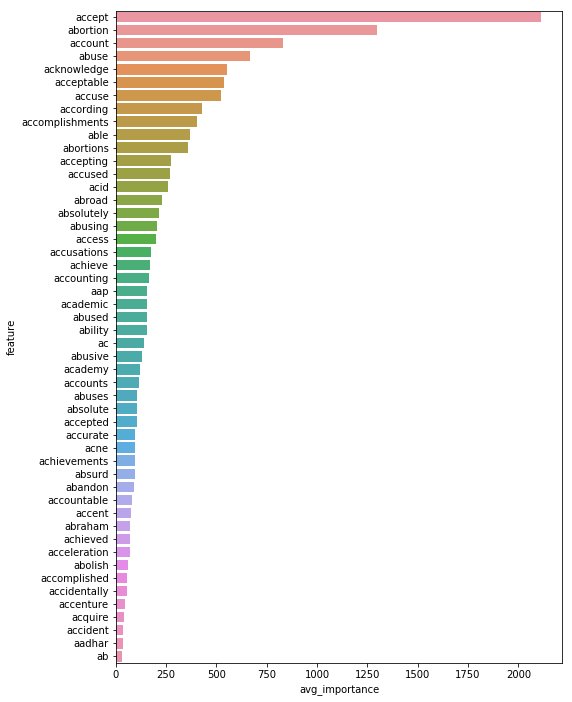

Selece Feature: 51
[Save Feature Importance] done in 1 s
51
['aadhar', 'aap', 'ab', 'abandon', 'ability', 'able', 'abolish', 'abortion', 'abortions', 'abraham', 'abroad', 'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'ac']
All done in 27 s
[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.219578
[400]	valid_0's binary_logloss: 0.218883
[600]	valid_0's binary_logloss: 0.21862
[800]	valid_0's binary_logloss: 0.218528
[1000]	valid_0's binary_logloss: 0.218507
Early stopping, best iteration is:
[932]	valid_0's binary_logloss: 0.218499
[Validation: 0 | LGBM Train] done in 14 s


2018-11-27 09:38:11,411 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.21849909188572575 
2018-11-27 09:38:11,412 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 500) 
2018-11-27 09:38:11,503 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.21767610316483454 
2018-11-27 09:38:11,589 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.21631562814730482 
2018-11-27 09:38:11,675 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.21376010659237502 
2018-11-27 09:38:11,762 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.2122877200628862 
2018-11-27 09:38:11,848 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.20970216029656144 
2018-11-27 09:38:11,934 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.20633386306666446 
2018-11-27 09:38:12,019 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.20289903813815832 
2018-11-27 0

[Validation: 0 | Prediction & Get F1 score] done in 6 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.219561
[400]	valid_0's binary_logloss: 0.218765
[600]	valid_0's binary_logloss: 0.218495
[800]	valid_0's binary_logloss: 0.218405
[1000]	valid_0's binary_logloss: 0.218394
Early stopping, best iteration is:
[939]	valid_0's binary_logloss: 0.21839
[Validation: 1 | LGBM Train] done in 14 s


2018-11-27 09:38:32,447 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.2183896930004682 
2018-11-27 09:38:32,448 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 500) 
2018-11-27 09:38:32,539 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.21908979927888025 
2018-11-27 09:38:32,626 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.2177244006012229 
2018-11-27 09:38:32,713 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.21572306109480438 
2018-11-27 09:38:32,800 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.21314052184847532 
2018-11-27 09:38:32,886 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.20962945100876135 
2018-11-27 09:38:32,972 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.20655037025992742 
2018-11-27 09:38:33,057 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.20249359521776258 
2018-11-27 09

[Validation: 1 | Prediction & Get F1 score] done in 7 s


2018-11-27 09:38:35,292 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.21838176420154612 
2018-11-27 09:38:35,489 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.2170200966155373 
2018-11-27 09:38:35,686 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.21474194036627817 
2018-11-27 09:38:35,884 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.2127120433589076 
2018-11-27 09:38:36,083 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.20966591606631996 
2018-11-27 09:38:36,279 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.20644151565074134 
2018-11-27 09:38:36,476 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.20269789354166315 
2018-11-27 09:38:36,673 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.1984495585669268 
2018-11-27 09:38:36,870 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18 is

,feature,0_importance,1_importance,avg_importance
344,americans,19753.134908,20359.878182,20056.506545
342,america,7613.554423,7451.705655,7532.630039
343,american,6188.289827,6336.126014,6262.207921
423,anti,4097.895839,4229.348684,4163.622262
498,arabs,2437.119521,2573.846784,2505.483152


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


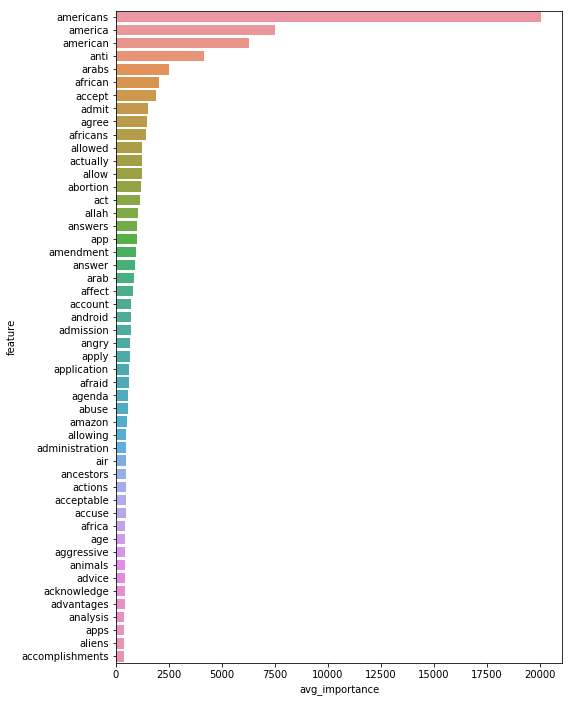

Selece Feature: 248
[Save Feature Importance] done in 0 s
248
['aap', 'abandon', 'ability', 'able', 'abolish', 'abortion', 'abortions', 'abraham', 'abroad', 'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'ac', 'academic', 'academy']
All done in 48 s
[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.211656
[400]	valid_0's binary_logloss: 0.209972
[600]	valid_0's binary_logloss: 0.209255
[800]	valid_0's binary_logloss: 0.208883
[1000]	valid_0's binary_logloss: 0.208689
[1200]	valid_0's binary_logloss: 0.208565
[1400]	valid_0's binary_logloss: 0.208502
Early stopping, best iteration is:
[1375]	valid_0's binary_logloss: 0.2085
[Validation: 0 | LGBM Train] done in 22 s


2018-11-27 09:39:09,878 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.20849988699714522 
2018-11-27 09:39:09,879 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 1000) 
2018-11-27 09:39:09,972 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.27840831396143856 
2018-11-27 09:39:10,060 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.27912313834237773 
2018-11-27 09:39:10,150 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.278798454443475 
2018-11-27 09:39:10,237 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.27782376203802245 
2018-11-27 09:39:10,324 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.27598860773359624 
2018-11-27 09:39:10,409 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.27474862725522353 
2018-11-27 09:39:10,495 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.2715059331814281 
2018-11-27 09

[Validation: 0 | Prediction & Get F1 score] done in 9 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.212016
[400]	valid_0's binary_logloss: 0.210204
[600]	valid_0's binary_logloss: 0.209421
[800]	valid_0's binary_logloss: 0.209002
[1000]	valid_0's binary_logloss: 0.208766
[1200]	valid_0's binary_logloss: 0.208629
[1400]	valid_0's binary_logloss: 0.208557
Early stopping, best iteration is:
[1439]	valid_0's binary_logloss: 0.208545
[Validation: 1 | LGBM Train] done in 24 s


2018-11-27 09:39:43,146 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.20854538201567224 
2018-11-27 09:39:43,147 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 1000) 
2018-11-27 09:39:43,250 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.28029996649064626 
2018-11-27 09:39:43,336 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.2806694378128143 
2018-11-27 09:39:43,423 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.2810155651952029 
2018-11-27 09:39:43,509 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.2800593503258969 
2018-11-27 09:39:43,595 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.277872169961184 
2018-11-27 09:39:43,680 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.27474561919660156 
2018-11-27 09:39:43,765 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.27092333819980335 
2018-11-27 09:3

[Validation: 1 | Prediction & Get F1 score] done in 9 s


2018-11-27 09:39:45,986 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.27934755793205923 
2018-11-27 09:39:46,187 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.2798909609517448 
2018-11-27 09:39:46,388 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.2798940798184225 
2018-11-27 09:39:46,588 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.2789369182767469 
2018-11-27 09:39:46,789 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.2769262506446622 
2018-11-27 09:39:46,989 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.27474712791679184 
2018-11-27 09:39:47,189 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.2712156303818517 
2018-11-27 09:39:47,388 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.2673865496092137 
2018-11-27 09:39:47,586 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.

,feature,0_importance,1_importance,avg_importance
344,americans,19999.786743,20701.962490,20350.874616
927,best,10170.379667,10808.587313,10489.483490
342,america,7349.096525,7060.116906,7204.606716
343,american,6133.332547,6225.217489,6179.275018
895,believe,5945.586875,5527.451598,5736.519236


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


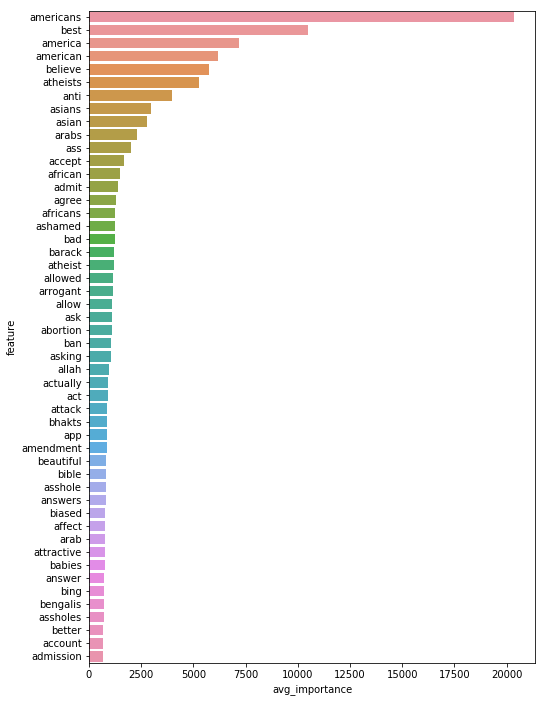

Selece Feature: 451
[Save Feature Importance] done in 0 s
451
['aap', 'abandon', 'ability', 'able', 'abortion', 'abortions', 'abroad', 'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'ac', 'academic', 'academy', 'acceleration', 'accent']
All done in 71 s
[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.200173
[400]	valid_0's binary_logloss: 0.19696
[600]	valid_0's binary_logloss: 0.195486
[800]	valid_0's binary_logloss: 0.194636
[1000]	valid_0's binary_logloss: 0.194087
[1200]	valid_0's binary_logloss: 0.193707
[1400]	valid_0's binary_logloss: 0.193451
[1600]	valid_0's binary_logloss: 0.193287
[1800]	valid_0's binary_logloss: 0.193177
[2000]	valid_0's binary_logloss: 0.193086
[2200]	valid_0's binary_logloss: 0.193047
[2400]	valid_0's binary_logloss: 0.193039
Early stopping, best iteration is:
[2350]	valid_0's binary_logloss: 0.193029
[Validation: 0 | LGBM Train] done in 41 

2018-11-27 09:40:43,946 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.19302935329345028 
2018-11-27 09:40:43,947 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 2000) 
2018-11-27 09:40:44,052 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.3436500497637431 
2018-11-27 09:40:44,143 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.34859520262982174 
2018-11-27 09:40:44,234 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.3519902923140263 
2018-11-27 09:40:44,322 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.3554468399795209 
2018-11-27 09:40:44,411 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.3571217056559076 
2018-11-27 09:40:44,499 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.3566532183893951 
2018-11-27 09:40:44,588 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.35483256505009714 
2018-11-27 09:4

[Validation: 0 | Prediction & Get F1 score] done in 13 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.199995
[400]	valid_0's binary_logloss: 0.19667
[600]	valid_0's binary_logloss: 0.195062
[800]	valid_0's binary_logloss: 0.194131
[1000]	valid_0's binary_logloss: 0.193518
[1200]	valid_0's binary_logloss: 0.193101
[1400]	valid_0's binary_logloss: 0.192823
[1600]	valid_0's binary_logloss: 0.192628
[1800]	valid_0's binary_logloss: 0.192472
[2000]	valid_0's binary_logloss: 0.192387
[2200]	valid_0's binary_logloss: 0.192325
[2400]	valid_0's binary_logloss: 0.192303
Early stopping, best iteration is:
[2430]	valid_0's binary_logloss: 0.192294
[Validation: 1 | LGBM Train] done in 42 s


2018-11-27 09:41:39,553 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.19229411381763672 
2018-11-27 09:41:39,554 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 2000) 
2018-11-27 09:41:39,656 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.34917999159967567 
2018-11-27 09:41:39,746 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.35311949024096007 
2018-11-27 09:41:39,836 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.35579894811039414 
2018-11-27 09:41:39,925 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.35679639286771564 
2018-11-27 09:41:40,014 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.35850669706469085 
2018-11-27 09:41:40,102 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.3581661891117479 
2018-11-27 09:41:40,189 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.3564125261388857 
2018-11-27 0

[Validation: 1 | Prediction & Get F1 score] done in 14 s


2018-11-27 09:41:42,467 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.34640008549250484 
2018-11-27 09:41:42,671 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.3508531790955684 
2018-11-27 09:41:42,877 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.3538937635830538 
2018-11-27 09:41:43,081 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.35612135146055396 
2018-11-27 09:41:43,286 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.35781334313719676 
2018-11-27 09:41:43,490 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.357407008583823 
2018-11-27 09:41:43,692 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.35561852248940623 
2018-11-27 09:41:43,895 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.353870458135861 
2018-11-27 09:41:44,098 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.

,feature,0_importance,1_importance,avg_importance
344,americans,19420.600161,20207.110879,19813.855520
1002,black,14233.399856,12850.900033,13542.149945
927,best,9574.313338,10199.391871,9886.852604
1541,chinese,8180.646587,8435.852684,8308.249636
1560,christians,7468.063071,6726.428863,7097.245967


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


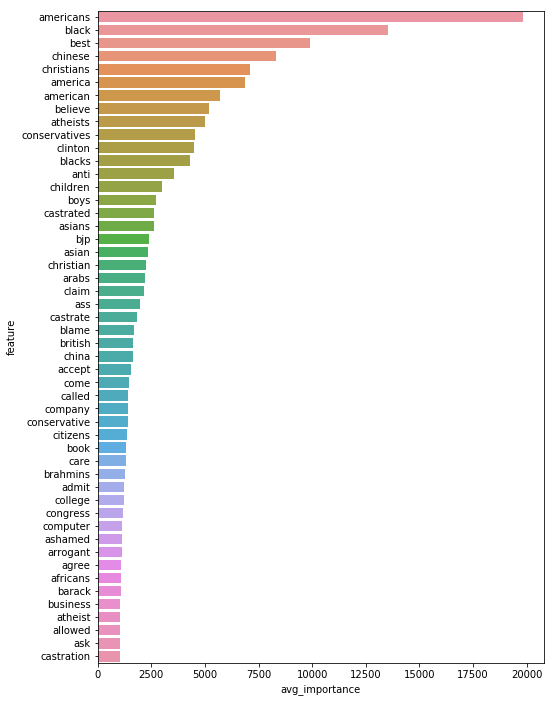

Selece Feature: 798
[Save Feature Importance] done in 0 s
798
['aap', 'abandon', 'ability', 'able', 'abortion', 'abortions', 'abroad', 'absolutely', 'absurd', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'ac', 'academic', 'academy', 'acceleration', 'accent', 'accept']
All done in 116 s
[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.176729
[400]	valid_0's binary_logloss: 0.170592
[600]	valid_0's binary_logloss: 0.167565
[800]	valid_0's binary_logloss: 0.165717
[1000]	valid_0's binary_logloss: 0.16446
[1200]	valid_0's binary_logloss: 0.163549
[1400]	valid_0's binary_logloss: 0.162888
[1600]	valid_0's binary_logloss: 0.162383
[1800]	valid_0's binary_logloss: 0.161974
[2000]	valid_0's binary_logloss: 0.161685
[2200]	valid_0's binary_logloss: 0.161434
[2400]	valid_0's binary_logloss: 0.161225
[2600]	valid_0's binary_logloss: 0.161091
[2800]	valid_0's binary_logloss: 0.160981
[3000]	valid_0's binary_logloss: 0

2018-11-27 09:43:25,682 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.16079794723746413 
2018-11-27 09:43:25,683 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 5000) 
2018-11-27 09:43:25,778 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.45040776500464436 
2018-11-27 09:43:25,870 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.4590928586746729 
2018-11-27 09:43:25,960 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.46582193442439396 
2018-11-27 09:43:26,051 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.4707236174101401 
2018-11-27 09:43:26,141 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.4750050110242534 
2018-11-27 09:43:26,230 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.47818119700593226 
2018-11-27 09:43:26,319 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.4810291309773971 
2018-11-27 09:

[Validation: 0 | Prediction & Get F1 score] done in 20 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.176685
[400]	valid_0's binary_logloss: 0.170674
[600]	valid_0's binary_logloss: 0.167637
[800]	valid_0's binary_logloss: 0.165755
[1000]	valid_0's binary_logloss: 0.164493
[1200]	valid_0's binary_logloss: 0.163577
[1400]	valid_0's binary_logloss: 0.162903
[1600]	valid_0's binary_logloss: 0.162372
[1800]	valid_0's binary_logloss: 0.161987
[2000]	valid_0's binary_logloss: 0.161666
[2200]	valid_0's binary_logloss: 0.161425
[2400]	valid_0's binary_logloss: 0.161228
[2600]	valid_0's binary_logloss: 0.161071
[2800]	valid_0's binary_logloss: 0.160929
[3000]	valid_0's binary_logloss: 0.160843
[3200]	valid_0's binary_logloss: 0.160755
[3400]	valid_0's binary_logloss: 0.160722
[3600]	valid_0's binary_logloss: 0.160704
[3800]	valid_0's binary_logloss: 0.160707
Early stopping, best iteration is:
[3701]	valid_0's binary_logloss: 0.160696
[Validati

2018-11-27 09:45:07,360 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.16069559694444896 
2018-11-27 09:45:07,361 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 5000) 
2018-11-27 09:45:07,457 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.4517715607728889 
2018-11-27 09:45:07,548 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.461250427550451 
2018-11-27 09:45:07,640 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.467298320077376 
2018-11-27 09:45:07,730 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.47257112811824503 
2018-11-27 09:45:07,820 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.4770135226436214 
2018-11-27 09:45:07,910 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.480747616867169 
2018-11-27 09:45:07,999 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.4827534525211434 
2018-11-27 09:45:08

[Validation: 1 | Prediction & Get F1 score] done in 21 s


2018-11-27 09:45:10,316 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.4510877924563772 
2018-11-27 09:45:10,526 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.46016770548405905 
2018-11-27 09:45:10,736 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.4665577744808511 
2018-11-27 09:45:10,944 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.47164419517449163 
2018-11-27 09:45:11,151 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.47600617249820304 
2018-11-27 09:45:11,357 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.4794610837489556 
2018-11-27 09:45:11,562 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.4818897301225161 
2018-11-27 09:45:11,767 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.48358310589294834 
2018-11-27 09:45:11,971 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 

,feature,0_importance,1_importance,avg_importance
344,americans,17365.066026,18069.231361,17717.148694
4451,indians,16151.547831,17271.040197,16711.294014
1002,black,13736.673532,12196.488718,12966.581125
3789,girls,13079.205502,10434.946026,11757.075764
2414,democrats,9909.296374,11261.372773,10585.334573


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


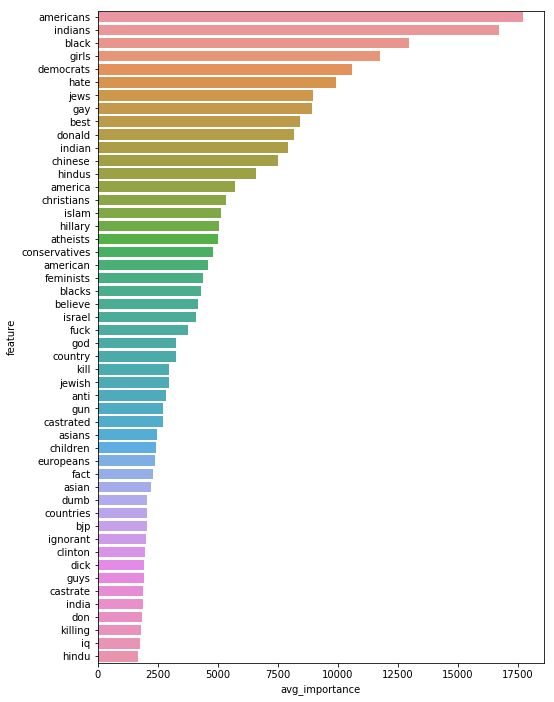

Selece Feature: 1487
[Save Feature Importance] done in 0 s
1487
['aap', 'ability', 'able', 'abortion', 'abortions', 'abroad', 'abuse', 'abused', 'abusing', 'abusive', 'ac', 'academic', 'academy', 'accent', 'accept', 'acceptable', 'accepting', 'access', 'accomplishments', 'according']
All done in 208 s
[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.156096
[400]	valid_0's binary_logloss: 0.148567
[600]	valid_0's binary_logloss: 0.144661
[800]	valid_0's binary_logloss: 0.142211
[1000]	valid_0's binary_logloss: 0.140572
[1200]	valid_0's binary_logloss: 0.139326
[1400]	valid_0's binary_logloss: 0.138412
[1600]	valid_0's binary_logloss: 0.137674
[1800]	valid_0's binary_logloss: 0.137079
[2000]	valid_0's binary_logloss: 0.136624
[2200]	valid_0's binary_logloss: 0.136248
[2400]	valid_0's binary_logloss: 0.135943
[2600]	valid_0's binary_logloss: 0.135707
[2800]	valid_0's binary_logloss: 0.135505
[3000]	valid_0's binary

2018-11-27 09:47:40,264 __main__ 127 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.13483090087105498 
2018-11-27 09:47:40,265 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 9000) 
2018-11-27 09:47:40,360 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5233779384566459 
2018-11-27 09:47:40,451 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5329995567029128 
2018-11-27 09:47:40,542 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5406761825099161 
2018-11-27 09:47:40,633 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.547071313991117 
2018-11-27 09:47:40,723 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5519134537482725 
2018-11-27 09:47:40,813 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5558590575772707 
2018-11-27 09:47:40,903 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5597156540859665 
2018-11-27 09:47:4

[Validation: 0 | Prediction & Get F1 score] done in 25 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.155888
[400]	valid_0's binary_logloss: 0.148385
[600]	valid_0's binary_logloss: 0.14459
[800]	valid_0's binary_logloss: 0.142155
[1000]	valid_0's binary_logloss: 0.140475
[1200]	valid_0's binary_logloss: 0.139248
[1400]	valid_0's binary_logloss: 0.138331
[1600]	valid_0's binary_logloss: 0.137587
[1800]	valid_0's binary_logloss: 0.137023
[2000]	valid_0's binary_logloss: 0.136573
[2200]	valid_0's binary_logloss: 0.136157
[2400]	valid_0's binary_logloss: 0.135843
[2600]	valid_0's binary_logloss: 0.135583
[2800]	valid_0's binary_logloss: 0.135346
[3000]	valid_0's binary_logloss: 0.135168
[3200]	valid_0's binary_logloss: 0.135024
[3400]	valid_0's binary_logloss: 0.134932
[3600]	valid_0's binary_logloss: 0.134834
[3800]	valid_0's binary_logloss: 0.134771
[4000]	valid_0's binary_logloss: 0.134742
[4200]	valid_0's binary_logloss: 0.134714
Ear

2018-11-27 09:50:02,575 __main__ 127 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.1347119962640972 
2018-11-27 09:50:02,576 __main__ 128 [INFO]    [lgbm_train] Train Shape: (653061, 9000) 
2018-11-27 09:50:02,671 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5230740867991251 
2018-11-27 09:50:02,763 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5332961487846754 
2018-11-27 09:50:02,855 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5410017950406365 
2018-11-27 09:50:02,947 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5476742130288734 
2018-11-27 09:50:03,036 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5539615852082954 
2018-11-27 09:50:03,126 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5572124641439742 
2018-11-27 09:50:03,216 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5606245278267439 
2018-11-27 09:50:0

[Validation: 1 | Prediction & Get F1 score] done in 24 s


2018-11-27 09:50:05,550 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5232261144096538 
2018-11-27 09:50:05,762 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.533147656555986 
2018-11-27 09:50:05,972 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5408387526796492 
2018-11-27 09:50:06,181 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5473722342974976 
2018-11-27 09:50:06,385 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.55293544597576 
2018-11-27 09:50:06,590 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5565346160824176 
2018-11-27 09:50:06,798 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5601693551631199 
2018-11-27 09:50:07,005 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.5632766471995678 
2018-11-27 09:50:07,211 __main__ 24 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.56558

,feature,0_importance,1_importance,avg_importance
6558,people,36531.484979,36156.611537,36344.048258
344,americans,19598.774026,20375.973134,19987.373580
5912,muslims,20791.694344,18638.188339,19714.941341
5618,men,19099.426577,19093.948293,19096.687435
5171,liberals,17127.527317,17679.912579,17403.719948


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


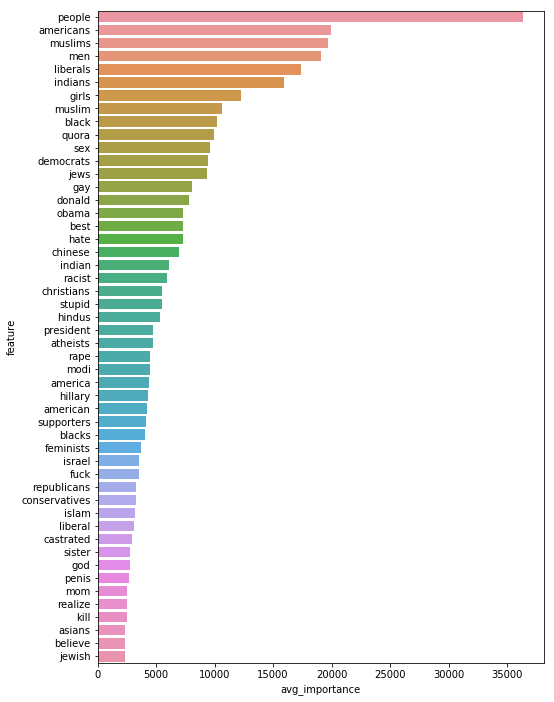

Selece Feature: 1948
[Save Feature Importance] done in 0 s
1948
['ability', 'able', 'abortion', 'abortions', 'abuse', 'abusing', 'accept', 'acceptable', 'according', 'account', 'accusations', 'accuse', 'achieve', 'acid', 'acknowledge', 'act', 'acting', 'actions', 'active', 'activists']
All done in 295 s
exp100: 26.66825032234192
exp500: 47.9951868057251
exp1000: 70.90393614768982
exp2000: 116.4349889755249
exp5000: 207.91224193572998
exp9000: 295.28548765182495


In [11]:
time_list = []
exp_list = [100, 500, 1000, 2000, 5000, 9000]
for i in exp_list:
    train_st_time = time.time()
    tmp_train = csr_tfidf.T[:i].T
    select_features, _ = lgbm_train(tmp_train, feature_list[:i], fold=2)
    train_time = time.time() - train_st_time
    time_list.append(train_time)

for time, exp in zip(time_list, exp_list):
    print(f"exp{exp}: {time}")

In [14]:
print(f'All Done!! {time.time() - st_time:.0f} s')

NameError: name 'train_st_time' is not defined